# Ising 1D transverse field model
## Ground state energy, magnetization and susceptibility

### Libraries

In [1]:
## Basic libraries for printing output, plots, etc.
using Printf
using Plots
using Random

## Libraries for Sparse Arrays
using SparseArrays
using ArnoldiMethod # Solves eigenvalue problems with sparse matrices

## Other libraries
using LinearAlgebra
using Statistics # For statistical measurements
using QuadGK # For numerical integration

### Functions for exact ground state

In [2]:
# Redefinition of tensor product
function ⊙(x,y)
    kron(x,y)
end

# Sparse Hamiltonian
function buildHamiltonian_sparse(;N,J,B)
    #  Input: -----------------------------
    #
    #  N: Number of spins in the chain
    #
    #  J: Hamiltonian interaction term
    #
    #  B: Transverse magnetic field
    #  term
    #
    #  Output: ----------------------------
    #
    #  H: Hamiltonian matrix projected
    #  onto spin basis
    
    Id = [[1,0] [0,1]] |> sparse
    σᶻ = [[1,0] [0,-1]] |> sparse
    σˣ = [[0,1] [1,0]] |> sparse
    
    # Coupling term
    first_term = fill(Id, N)
    first_term[1] = σᶻ
    first_term[2] = σᶻ
    
    second_term = fill(Id, N)
    second_term[1] = σˣ
    
    # Initialize sparse zero matrix
    H = spzeros(Float64, 2^N, 2^N)
    for i in 1:N
        H += -J*foldl(⊙, first_term) -B*foldl(⊙, second_term)
        first_term = circshift(first_term, 1)
        second_term = circshift(second_term, 1)
    end
    return H
end

# Sparse eigenvalues
function eigen_sparse(x)
    decomp, history = partialschur(x, nev=1, which=:SR) # only solve for the ground state
    vals, vecs = partialeigen(decomp)
    return vals, vecs
end

# Magnetization of a given state
function buildMagnetizations_sparse(state; N)
    # Input: ------------------------------
    #
    # state: column vector or matrix of vectors
    # encoding a projected wavestate onto the
    # spin basis of the Ising model
    #
    # N: Number of spins in the chain
    # 
    # Output: -----------------------------
    #
    # st_mz: value of the longitudinal
    # magnetization
    #
    # st_mx: value of the transversal
    # magnetization
    
    Id = [[1,0] [0,1]] |> sparse
    σᶻ = [[1,0] [0,-1]] |> sparse
    σˣ = [[0,1] [1,0]] |> sparse
    
    mz = fill(Id,N)
    mz[1] = σᶻ
    
    mx = fill(Id,N)
    mx[1] = σˣ
    
    # Build magnetizations
    Mz = spzeros(Float64, 2^N, 2^N)
    Mx = spzeros(Float64, 2^N, 2^N)
    for i in 1:N
        Mz += foldl(⊙, mz)/N
        Mx += foldl(⊙, mx)/N
        mz = circshift(mz, 1)
        mx = circshift(mx, 1)
    end
    
    # Calculate magnetization of the state
    st_mz = sqrt(state'*Mz^2*state)
    st_mx = sqrt(state'*Mx^2*state)
    
    return st_mz, st_mx
end

# Magnetization in the thermodynamic limit (integral)
function magnetizationIntegral(;J,B)
    # Input: -----------------------------
    #
    # J: Hamiltonian interaction term
    #
    # B: Transverse magnetic field term
    #
    # Output: ----------------------------
    #
    # in_mz: value of the longitudinal
    # magnetization in the thermodynamic limit
    #
    # in_mx: value of the transversal
    # magnetization in the thermodynamic limit
    
    in_mz = (B < J) ? (1 - B^2/J^2)^(1/8) : 0
    
    in_mx, err = quadgk(k -> (B + J*cos(k))/sqrt(J^2 + B^2 + 2*J*B*cos(k)), 
        0, pi, rtol=1e-10)
    
    return in_mz, in_mx/pi
end;

### RBM Class definition

In [3]:
# RBM wavefunction class
mutable struct RBM
    nv::Int
    nh::Int
    params::Vector{ComplexF64}
    
    function RBM(nv::Int, nh::Int; σ::Float64=0.01)
        rbm = new(nv, nh, ComplexF64[])
        initialise_RBM!(rbm; σ)
        return rbm
    end
end

# Initialize RBM wavefunction
function initialise_RBM!(rbm::RBM; σ::Float64)
    # Parameters of the RBM can be complex valued,
    # and are initialized from a random distribution
    b = randn(ComplexF64, rbm.nv)
    c = randn(ComplexF64, rbm.nh)
    W = randn(ComplexF64, rbm.nh, rbm.nv)
    
    rbm.params = σ * vcat(b, c, vec(W))
end

# Define property-like functions
function b(rbm::RBM)
    # Returns column vector of visible bias
    return rbm.params[1:rbm.nv]
end

function c(rbm::RBM)
    # Returns column vector of hidden bias
    return rbm.params[rbm.nv+1 : rbm.nv+rbm.nh]
end

function W(rbm::RBM)
    # Returns nh x nv weight matrix
    nv, nh = rbm.nv, rbm.nh
    return reshape(rbm.params[nv+nh+1:end], (nh, nv))
end
    
# Additional functions that may be useful
function wavefunction(rbm::RBM, s::Vector{Bool})
    ## Projection of the wavefunction onto state s
    return exp(dot(b(rbm),s)) * prod(cosh.(c(rbm) .+ W(rbm) * s)) * 2^rbm.nh
end

function p_ratio(rbm::RBM, s1::Vector{Bool}, s2::Vector{Bool})
    ## Probability ratio between state s2 and reference state s1
    p1 = cosh.(c(rbm) .+ W(rbm) * s1)
    p2 = cosh.(c(rbm) .+ W(rbm) * s2)
    log_diff = b(rbm)' * (s2 - s1) + sum(log.(p2 ./ p1))  # log of ratio for numerical stability
    return exp(log_diff)
end

function p_ratios(rbm::RBM, s1::Vector{Bool}, s2::Vector{Vector{Bool}})
    ## Probability ratios between list of states s2 and reference state s1
    return [p_ratio(rbm, s1, s) for s in s2]
end;

### Useful functions for variational monte carlo

In [4]:
# Flip i-th bit of state s
function flip(s::Vector{Bool}, i)
    s_flip = copy(s)
    s_flip[i] = .!s_flip[i]
    return s_flip
end

# Local energy of the TFI model
function local_energy(s::Vector{Bool}, psi::RBM; pbc::Bool=true, J=2, B=1)
    # Interaction term
    couplings = (s[1:end-1] .== s[2:end]) .* 2 .- 1
    e_int = -J * sum(couplings)

    # Add Periodic Boundary Conditions
    if pbc
        e_int -= J * ((s[end] == s[1]) * 2 - 1)
    end
    
    # Transverse field term
    flipped_states = [flip(s,i) for i in 1:length(s)]
    e_field = -B * sum(p_ratios(psi, s, flipped_states))
    
    return e_int + e_field
end

# Compute the log-derivative of the wavefunction
function variational_derivative(s::Vector{Bool}, psi::RBM)
    theta = c(psi) .+ W(psi) * s  # Column of length n_hidden
    Ob = s                        # Column of length n_visible
    Oc = tanh.(theta)
    Ow = Oc * s'                  # Matrix of n_hidden x n_visible
    return vcat(Ob, Oc, vec(Ow))
end

# Compute the covariance between x1 and x2
# Used for calculating the gradient:
#
# F = covariance(conj.(O),EL) -> x1 is num_params x num_samples and EL is num_samples x 1
#
# and for the Fischer matrix:
#
# S = covariance(conj.(O),O) -> x1, x2 are num_params x num_samples
function covariance(s1::AbstractMatrix, s2::AbstractVector)
    samples = size(s1,2)                              # Number of columns (samples) in x1
    m1 = mean(s1, dims=2)                             # This is num_params x 1
    m2 = mean(s2)                                     # This is a number
    return (s1 * s2) / samples - m1 * m2
end

function covariance(s1::AbstractMatrix, s2::AbstractMatrix)
    samples = size(s1,2)                              # Number of columns (samples) in x1
    m1 = mean(s1, dims=2)                             # This is num_params x 1
    m2 = mean(s2, dims=2)                             # This is num_params x 1
    return (s1 * s2')/samples - m1 * m2'
end

# Sample bs states according to our wavefunction
function sample_block(psi::RBM, bs::Int; s0=nothing, n_flips=1)
    state = s0 === nothing ? rand(Bool, psi.nv) : s0
    states = Vector{Vector{Bool}}()
    for _ in 1:bs
        idx = rand(1:psi.nv, n_flips)
        new_state = flip(state, idx)
        if rand() <= abs(p_ratio(psi, state, new_state))^2
            state = copy(new_state)   # Accept new state   
        end
        push!(states,copy(state))
    end
    return states
end;

### Binning analysis functions

In [5]:
# Mean of the time-series x in chunks of given size
function bin_averages(x, bs)
    nb = length(x) ÷ bs
    bin_avg = [mean(x[(b-1)*bs+1:b*bs]) for b in 1:nb]
    return bin_avg
end;

## main code

### Ground state and ground energy

Calculate the ground state energy given the number of spins $N$, the coupling interaction term $J$ and the strength of the transverse magnetic field $B$.

### Ground state magnetization

Calculate the longitudinal and transversal magnetizations of the ground state.

### Plot of the phase transition

We calculate the longitudinal magnetization of the ground state for different values of $B/J$ and plot it for many $N$:

## Variational Monte Carlo using RBM wavefunction

### Monte Carlo sampling by flipping spins randomly

In [6]:
## Parameters of the problem
Random.seed!(7)
n = 2                                   # Number of spins
J, B = 2.0, 1.0                         # Hamiltonian
n_visible, n_hidden = n, 1              # RBM size: twice as many hidden neurons
psi = RBM(n_visible, n_hidden, σ=0.1);  # Randomly initialize our anstaz

psi.params = [1,1,1,1,1]

local_energy([true,true],psi)

-4.274946546476014 - 0.0im

### Calculate autocorrelation time of the samples

### Stochastic Reconfiguration (Natural Gradient) learning

  4.025221 seconds (14.86 M allocations: 733.104 MiB, 6.02% gc time, 99.71% compilation time)


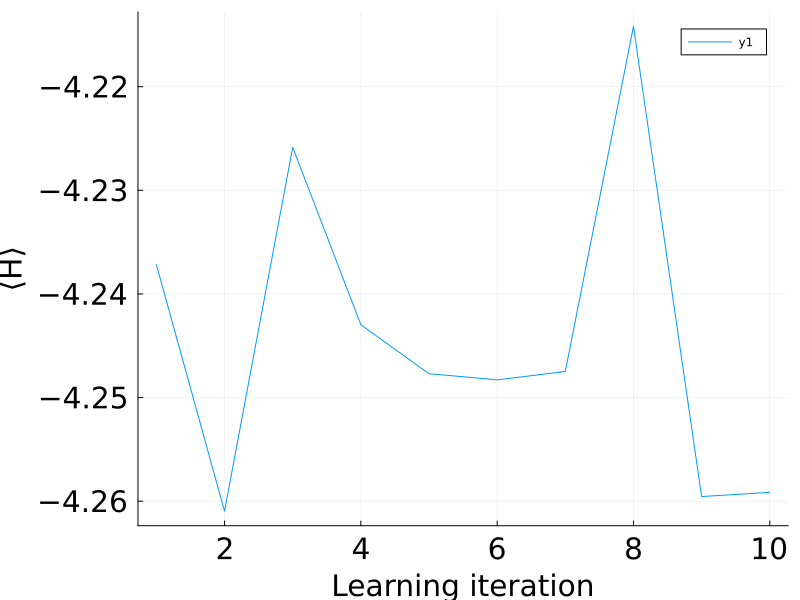

In [7]:
## Learning parameters
learning_iterations = 10
lr = 1e-2
n_blocks = 150
thermalise = Int(0.1*n_blocks)
Nb = n_blocks - thermalise
bs = 1
n_flips = 1
energies = ComplexF64[]

@time for it in 1:learning_iterations
    EL = zeros(ComplexF64,Nb) 
    O = zeros(ComplexF64,length(psi.params),Nb)
    states = sample_block(psi, thermalise * bs; n_flips=n_flips)
    state = states[end]
    for k in 1:Nb
        batch = sample_block(psi, bs; s0=state, n_flips=n_flips)
        append!(states,batch) # append! iterates through batch, while push! adds it whole
        state = batch[end]
        EL[k] = local_energy(state, psi; J=J, B=B)
        O[:,k] = variational_derivative(state, psi)
    end
    
    push!(energies,mean(EL))
    
    F = covariance(conj.(O), EL)           # Gradient
    S = covariance(conj.(O), O)            # Fisher info
    Sinv = pinv(S, rtol=1e-5)              # (pseudo)Inversion
    d_params = lr * Sinv * F
    psi.params .-= vec(d_params)
end

p3 = plot(real(energies),size=(800,600),grid=true)
plot!(p3,xlab="Learning iteration",xtickfontsize=20,xguidefontsize=20)
plot!(p3,ylab="⟨H⟩",ytickfontsize=20,yguidefontsize=20)

In [8]:
energy = real(energies[end-100:end])
print("The obtained energy is: $(round(mean(energy),digits=4)) +- $(round(std(energy)/10,digits=4))")

The obtained energy is: -4.4427 +- 0.0028